In [23]:
import psycopg2
import pandas as pd
import numpy as np
import os
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit import DataStructs

from mordred import Calculator, descriptors, Lipinski
import mordred

import mlflow
from mlflow.models.signature import infer_signature
from mlflow.utils.environment import _mlflow_conda_env

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import f1_score, confusion_matrix, average_precision_score, roc_auc_score, recall_score, \
precision_score, accuracy_score, precision_recall_curve
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import KFold
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion, Pipeline, make_pipeline
from sklearn.decomposition import PCA

from xgboost import XGBClassifier, plot_importance
from sklearn.linear_model import BayesianRidge, LinearRegression, LogisticRegression, RidgeClassifier, RidgeClassifierCV
import constants as co

import logging

from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

import pickle
import json
from data_transformers import data_load

from IPython.display import IFrame

import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_columns', None)
random_seed = 42

%config Completer.use_jedi = False

logging.basicConfig(stream=sys.stdout)
logger = logging.getLogger(name=__name__)
logger.setLevel(logging.DEBUG)

In [24]:
logger.info(os.getcwd())

INFO:__main__:/home/rafalb/work/molecules/moleculeGenerator/moleculegenerator/moleculegenerator/notebooks/activity_prediction/activity_prediction_app_devel/notebook


In [25]:
def set_up_mlflow(experiment):
    server_ip = "10.210.200.190"
    os.environ['AWS_ACCESS_KEY_ID'] = 'mlflow'
    os.environ['AWS_SECRET_ACCESS_KEY'] = 'uSPmPqTZv4YQh8M7oMqq'
    os.environ['MLFLOW_S3_ENDPOINT_URL'] = f"http://{server_ip}:9000"
    mlflow.set_tracking_uri(f"http://{server_ip}:9002")
    mlflow.set_experiment(experiment)

In [26]:
logger.debug(os.environ['CONDA_DEFAULT_ENV'])

DEBUG:__main__:rorgammaqsar


In [27]:
data_ic50_raw = pd.read_csv(co.DATA_DIR/"ror_gamma_homo_sapiens_chembl_3.0_IC50.csv")
max_level_activity = 15
act_cols = ["act_"+str(iii) for iii in range(max_level_activity)]
ic50_std = data_ic50_raw[act_cols].apply(lambda x: np.std(x), axis=1)

In [28]:
data_ic50_raw.shape

(2472, 21)

<AxesSubplot:>

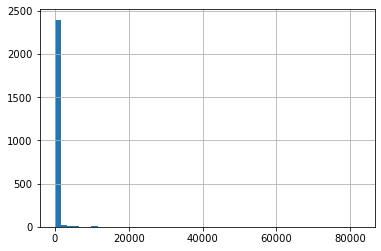

In [29]:
ic50_std.hist(bins=50)

<AxesSubplot:>

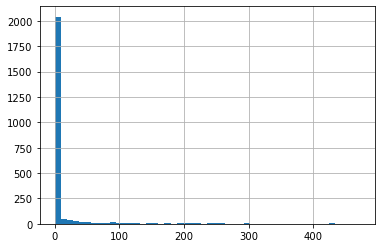

In [30]:
ic50_std[ic50_std<500].hist(bins=50)

In [31]:
ic50_std[ic50_std<500].shape

(2343,)

In [32]:
ic50_std[ic50_std<500].shape[0]/ic50_std.shape[0]

0.9478155339805825

In [33]:
ic50_std[ic50_std<500].shape[0]-ic50_std.shape[0]

-129

In [36]:
configuration = {
    "data_file": "ror_gamma_homo_sapiens_chembl_3.0_IC50.csv",
    "max_level_activity": 15,
    "std_threshold": 1000000,
    "strategy": "median"
}
data_ic50 = data_load(configuration=configuration).sort_values("IC50_nM")
data_ic50

,canonical_smiles_get_levels,IC50_nM
1671,CC(C)(C)NS(=O)(=O)c1ccc(-c2sc(C(=O)NCC(C)(C)C(...,0.37
1660,CC(C)(C)NS(=O)(=O)c1ccc(-c2sc(C(=O)NC3CCOCC3)n...,0.69
1686,CCC(C)(C)NS(=O)(=O)c1ccc(-c2sc(C(=O)N[C@H]3C[C...,0.71
435,Cc1cc(Cl)ccc1C(NC(=O)Cc1ccc(OCc2c(C)noc2C)cc1)...,1.00
436,Cc1cnc(C(CCC(C)C)NC(=O)Cc2ccc3oc(C(O)c4c(C)noc...,1.00
...,...,...
356,CCN1C(=O)c2cccc3c(S(=O)(=O)Nc4ccccc4C(=O)c4ccc...,156300.00
376,NC(=O)c1ccc(NC(=O)c2cccc(COc3ccc(Cl)cc3)c2)cc1,168270.00
369,CCN1C(=O)c2cccc3c(S(=O)(=O)NCc4ccc(OC)cc4)ccc1c23,174400.00
1730,CCOc1ccc(NC(C)=O)cc1Cl,216000.00


In [37]:
data_ic50[data_ic50["IC50_nM"] < 1000]

,canonical_smiles_get_levels,IC50_nM
1671,CC(C)(C)NS(=O)(=O)c1ccc(-c2sc(C(=O)NCC(C)(C)C(...,0.37
1660,CC(C)(C)NS(=O)(=O)c1ccc(-c2sc(C(=O)NC3CCOCC3)n...,0.69
1686,CCC(C)(C)NS(=O)(=O)c1ccc(-c2sc(C(=O)N[C@H]3C[C...,0.71
435,Cc1cc(Cl)ccc1C(NC(=O)Cc1ccc(OCc2c(C)noc2C)cc1)...,1.00
436,Cc1cnc(C(CCC(C)C)NC(=O)Cc2ccc3oc(C(O)c4c(C)noc...,1.00
...,...,...
818,O=C(C1CCNCC1)N1CCC(c2ccc(C(OCc3c(F)cccc3F)(C(F...,960.00
1744,CCS(=O)(=O)c1ccc(CC(=O)Nc2cc(-c3ccc(C#N)cc3Cl)...,970.00
705,CC(C)CN(c1ccc(OC2CCN(S(C)(=O)=O)CC2)cc1)S(=O)(...,974.00
2402,Cc1cc(CNC(=O)Nc2cc(Cl)c(-c3ccccc3OC(F)(F)F)c(C...,995.50


In [14]:
data_ic50_active = data_ic50[data_ic50["IC50_nM"] < 1000]
ror_gamma_search = pd.DataFrame()
ror_gamma_search["smiles"] = data_ic50_active["canonical_smiles_get_levels"]
ror_gamma_search["molregno"] = data_ic50_active.index
ror_gamma_search.to_csv("ror_gamma_search_active.smi", sep=" ", index=False)

<AxesSubplot:>

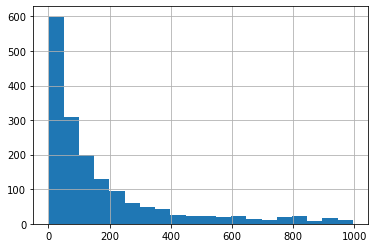

In [20]:
data_ic50_active["IC50_nM"].hist(bins=20)

In [15]:
ror_gamma_search

,smiles,molregno
1671,CC(C)(C)NS(=O)(=O)c1ccc(-c2sc(C(=O)NCC(C)(C)C(...,1671
1660,CC(C)(C)NS(=O)(=O)c1ccc(-c2sc(C(=O)NC3CCOCC3)n...,1660
1686,CCC(C)(C)NS(=O)(=O)c1ccc(-c2sc(C(=O)N[C@H]3C[C...,1686
435,Cc1cc(Cl)ccc1C(NC(=O)Cc1ccc(OCc2c(C)noc2C)cc1)...,435
436,Cc1cnc(C(CCC(C)C)NC(=O)Cc2ccc3oc(C(O)c4c(C)noc...,436
...,...,...
818,O=C(C1CCNCC1)N1CCC(c2ccc(C(OCc3c(F)cccc3F)(C(F...,818
1744,CCS(=O)(=O)c1ccc(CC(=O)Nc2cc(-c3ccc(C#N)cc3Cl)...,1744
705,CC(C)CN(c1ccc(OC2CCN(S(C)(=O)=O)CC2)cc1)S(=O)(...,705
2402,Cc1cc(CNC(=O)Nc2cc(Cl)c(-c3ccccc3OC(F)(F)F)c(C...,2402


In [38]:
mols = [Chem.MolFromSmiles(item) for item in ror_gamma_search["smiles"].tolist()]
fps = [AllChem.GetMorganFingerprint(mol, 2) for mol in mols]

In [40]:
query = "ClC1=CC(NC(CC2=CC=C(S(CC)(=O)=O)C=C2)=O)=CC(Cl)=C1C3=C(OC(F)(F)F)C=CC=C3"
fp_query = AllChem.GetMorganFingerprint(Chem.MolFromSmiles(query), 2)
max(DataStructs.BulkTanimotoSimilarity(fp_query, fps))

1.0

In [39]:
def get_max_sim(query_smiles, reference):
    fp_query = AllChem.GetMorganFingerprint(Chem.MolFromSmiles(query_smiles), 2)
    return max(DataStructs.BulkTanimotoSimilarity(fp_query, fps))

In [22]:
external_data = pd.read_parquet(co.DATA_DIR_CANDIDATES/"search_space_ror_gamma_all_active_found_species.parquet")
external_smiles = external_data["smiles"]
external_smiles.shape

(1950,)

In [48]:
for idx in range(external_data.shape[0]):
    print(get_max_sim(external_smiles.values.tolist()[idx], fps))

0.7954545454545454
0.7857142857142857
0.788235294117647
0.797752808988764
0.654320987654321
0.788235294117647
0.7906976744186046
1.0
0.8095238095238095
0.6463414634146342
0.7162162162162162
1.0
1.0
0.9146341463414634
1.0
1.0
0.6708860759493671
1.0
0.8709677419354839
0.8681318681318682
1.0
1.0
1.0
1.0
1.0
1.0
0.7613636363636364
1.0
1.0
0.8962264150943396
0.7938144329896907
0.7938144329896907
1.0
1.0
1.0
0.8795180722891566
0.845360824742268
0.6708860759493671
0.6463414634146342
1.0
1.0
0.9120879120879121
0.6986301369863014
0.9101123595505618
0.8795180722891566
0.8602150537634409
0.859375
1.0
1.0
1.0
1.0
1.0
0.7627118644067796
0.7627118644067796
0.7627118644067796
0.8333333333333334
0.74
0.7627118644067796
1.0
0.7647058823529411
0.845360824742268
1.0
1.0
0.8095238095238095
0.75
1.0
0.8315789473684211
0.6904761904761905
0.8118811881188119
0.8118811881188119
1.0
0.6376811594202898
0.84375
0.84375
1.0
0.8260869565217391
1.0
1.0
1.0
0.8504672897196262
0.654320987654321
1.0
1.0
1.0
0.891089108